#1. 🛠️ Preparación de los datos

##1.1 Carga de datos tratados

In [2]:
import pandas as pd

In [3]:
datos=pd.read_csv('/content/datos_tratados.csv')

In [4]:
datos.head(5)

,ID_Cliente,Cancelacion,Genero,Adulto_mayor,Pareja,Dependientes,Tiempo_contrato,Servicio_telefono,Lineas_multiples,Servicio_internet,...,Proteccion_dispositivo,Soporte_tecnico,TV_streaming,Películas_streaming,Tipo_contrato,Facturación_sin_papel,Metodo_pago,Cargo_mensual,Cargo_total,Cuentas_diarias
0,0002-ORFBO,0,Femenino,0,1,1,9,1,0,DSL,...,0,1,1,0,Un año,1,Cheque por correo,65.6,593.30,2.186667
1,0003-MKNFE,0,Masculino,0,0,0,9,1,1,DSL,...,0,0,0,1,Mes a mes,0,Cheque por correo,59.9,542.40,1.996667
2,0004-TLHLJ,1,Masculino,0,0,0,4,1,0,Fibra óptica,...,1,0,0,0,Mes a mes,1,Cheque electrónico,73.9,280.85,2.463333
3,0011-IGKFF,1,Masculino,1,1,0,13,1,0,Fibra óptica,...,1,0,1,1,Mes a mes,1,Cheque electrónico,98.0,1237.85,3.266667
4,0013-EXCHZ,1,Femenino,1,1,0,3,1,0,Fibra óptica,...,0,1,1,0,Mes a mes,1,Cheque por correo,83.9,267.40,2.796667


##1.2 Eliminación de columnas irrelevantes

Elimina columnas que **no aportan valor al análisis** o a **los modelos predictivos**, como identificadores únicos (por ejemplo, el ID del cliente). Estas columnas no ayudan en la predicción de la cancelación y pueden incluso perjudicar el desempeño de los modelos.

In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_Cliente              7043 non-null   object 
 1   Cancelacion             7043 non-null   int64  
 2   Genero                  7043 non-null   object 
 3   Adulto_mayor            7043 non-null   int64  
 4   Pareja                  7043 non-null   int64  
 5   Dependientes            7043 non-null   int64  
 6   Tiempo_contrato         7043 non-null   int64  
 7   Servicio_telefono       7043 non-null   int64  
 8   Lineas_multiples        7043 non-null   int64  
 9   Servicio_internet       7043 non-null   object 
 10  Seguridad_en_linea      7043 non-null   int64  
 11  Respaldo_en_linea       7043 non-null   int64  
 12  Proteccion_dispositivo  7043 non-null   int64  
 13  Soporte_tecnico         7043 non-null   int64  
 14  TV_streaming            7043 non-null   

In [6]:
import pandas as pd

datos_filtrados = datos.copy()

#Eliminacion de ID_Cliente directamente
datos_filtrados.drop(columns=['ID_Cliente'], inplace=True)

A. Evaluación de columnas candidatas a eliminar

In [7]:
# Evaluar si eliminar 'Genero' por tener distribución similar en cancelación
genero_churn = pd.crosstab(datos_filtrados['Genero'], datos_filtrados['Cancelacion'], normalize='index')
print("Distribución de cancelación por género:\n", genero_churn)

# Si existen diferencias < 2-3%, se puede eliminar
if abs(genero_churn.loc['Femenino', 1] - genero_churn.loc['Masculino', 1]) < 0.03:
    datos_filtrados.drop(columns=['Genero'], inplace=True)
    print("Columna 'Genero' eliminada por baja variabilidad respecto a la cancelación.")
else:
    print("Columna 'Genero' conservada.")

Distribución de cancelación por género:
 Cancelacion         0         1
Genero                         
Femenino     0.730791  0.269209
Masculino    0.738397  0.261603
Columna 'Genero' eliminada por baja variabilidad respecto a la cancelación.


In [8]:
# Evaluación de redundancia entre 'Servicio_telefono' y 'Lineas_multiples'
combinacion_telefonia = datos_filtrados[['Servicio_telefono', 'Lineas_multiples']].value_counts(normalize=True)
print("\nDistribución combinada de Servicio_telefono y Lineas_multiples:\n", combinacion_telefonia)

# Si todos los casos con Servicio_telefono=0 tienen Lineas_multiples=0 se asume una dependencia total
if datos_filtrados.loc[datos_filtrados['Servicio_telefono'] == 0, 'Lineas_multiples'].sum() == 0:
    datos_filtrados.drop(columns=['Lineas_multiples'], inplace=True)
    print("Columna 'Lineas_multiples' eliminada por dependencia total con 'Servicio_telefono'.")
else:
    print("Columna 'Lineas_multiples' conservada.")


Distribución combinada de Servicio_telefono y Lineas_multiples:
 Servicio_telefono  Lineas_multiples
1                  0                   0.481329
                   1                   0.421837
0                  0                   0.096834
Name: proportion, dtype: float64
Columna 'Lineas_multiples' eliminada por dependencia total con 'Servicio_telefono'.


In [9]:
# Verificación de si columna 'Cuentas_diarias' es derivada de 'Cargo_total' / (Tiempo_contrato * días promedio por mes)
datos_filtrados['Cuentas_diarias_calculada'] = datos_filtrados['Cargo_total'] / (datos_filtrados['Tiempo_contrato'] * 30.44)
corr = datos_filtrados[['Cuentas_diarias', 'Cuentas_diarias_calculada']].corr().iloc[0, 1]

print(f"\nCorrelación entre 'Cuentas_diarias' y valor calculado: {corr:.4f}")

if abs(corr) > 0.99:
    datos_filtrados.drop(columns=['Cuentas_diarias', 'Cuentas_diarias_calculada'], inplace=True)
    print("Columna 'Cuentas_diarias' eliminada por ser derivada casi exacta.")
else:
    datos_filtrados.drop(columns=['Cuentas_diarias_calculada'], inplace=True)  # solo columna auxiliar
    print("Columna 'Cuentas_diarias' conservada.")


Correlación entre 'Cuentas_diarias' y valor calculado: 0.9962
Columna 'Cuentas_diarias' eliminada por ser derivada casi exacta.


In [10]:
# Evaluaación de columna 'Cargo_total' debido a que tiene 11 valores nulos
nulos_cargo_total = datos_filtrados['Cargo_total'].isna().sum()
print(f"\nValores nulos en 'Cargo_total': {nulos_cargo_total}")

# Se imputan los nulos con la mediana de la columna, por lo que no se elimina
if nulos_cargo_total > 0:
    mediana_total = datos_filtrados['Cargo_total'].median()
    datos_filtrados['Cargo_total'].fillna(mediana_total, inplace=True)
    print("Valores nulos en 'Cargo_total' imputados con la mediana.")


Valores nulos en 'Cargo_total': 11
Valores nulos en 'Cargo_total' imputados con la mediana.


/tmp/ipython-input-3446487786.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos_filtrados['Cargo_total'].fillna(mediana_total, inplace=True)


**Resumen:**

- Eliminación segura de ID_Cliente
- Evaluación justificada de:
  - Genero (eliminada si hay poca diferencia)
  - Lineas_multiples (eliminada si depende totalmente de Servicio_telefono)
  - Cuentas_diarias (eliminada si es derivada de Cargo_total)
  - Cargo_total (imputación si hay nulos) -> no se elimina

##1.3 Encoding

Transforma las variables categóricas a formato numérico para hacerlas compatibles con los algoritmos de machine learning. Utiliza un método de codificación adecuado, como one-hot encoding.

🔎 **Sugerencia:**

Puedes consultar este artículo para entender mejor cuándo usar ```get_dummies``` o ```OneHotEncoder```:
Artículo en Alura sobre codificación categórica

In [11]:
# Identificación de variables categóricas restantes
cat_cols = datos_filtrados.select_dtypes(include='object').columns.tolist()
print("Columnas categóricas para codificar:", cat_cols)

Columnas categóricas para codificar: ['Servicio_internet', 'Tipo_contrato', 'Metodo_pago']


In [12]:
# Aplicación de get_dummies para codificación one-hot, eliminando la primera categoría para evitar multicolinealidad
datos_encoded = pd.get_dummies(datos_filtrados, columns=cat_cols, drop_first=True)
print("Forma final del dataframe codificado:", datos_encoded.shape)

Forma final del dataframe codificado: (7043, 22)


##1.4 Verificación de la proporción de cancelación (Churn)

Calcula la proporción de clientes que cancelaron en relación con los que permanecieron activos. Evalúa si existe un desbalance entre las clases, ya que esto puede impactar en los modelos predictivos y en el análisis de los resultados.

🔎 **Sugerencia:**

Puedes usar ```value_counts()``` de pandas para obtener esta proporción:

[Documentación oficial de](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html) ```value_counts()```

In [13]:
# Conteo absoluto y relativo de clases
conteo_churn = datos_encoded['Cancelacion'].value_counts()
proporcion_churn = datos_encoded['Cancelacion'].value_counts(normalize=True)

print("Conteo absoluto de cancelación:\n", conteo_churn)
print("\nProporción de cancelación:\n", proporcion_churn)

Conteo absoluto de cancelación:
 Cancelacion
0    5174
1    1869
Name: count, dtype: int64

Proporción de cancelación:
 Cancelacion
0    0.73463
1    0.26537
Name: proportion, dtype: float64


Visualización de proporciones

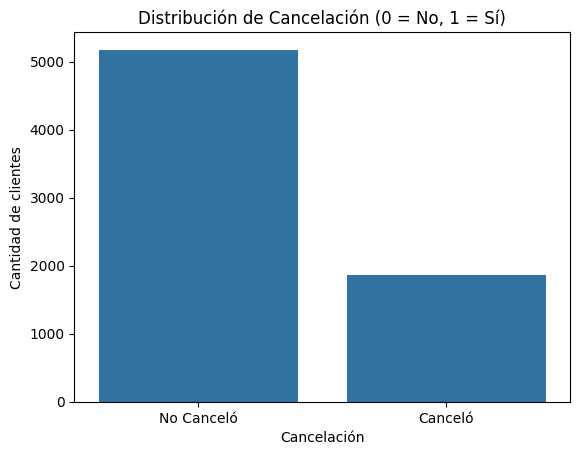

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Cancelacion', data=datos_encoded)
plt.title('Distribución de Cancelación (0 = No, 1 = Sí)')
plt.xlabel('Cancelación')
plt.ylabel('Cantidad de clientes')
plt.xticks([0, 1], ['No Canceló', 'Canceló'])
plt.show()

**Hallazgos importantes:**

- Alrededor del 26.5% de los clientes han cancelado.
- Hay un desbalance moderado (aproximadamente 3:1). Si bien no es un desbalance extremo, pero puede afectar métricas como precisión y F1-score en el modelo.
- Se confirma desbalance entre clases, por lo que se justifica considerar técnicas de balanceo (como SMOTE u oversampling) antes del modelado.

##1.5 Balanceo de clases (opcional)

Si deseas profundizar en el análisis, aplica técnicas de balanceo como **undersampling** o **oversampling**. En situaciones de fuerte desbalanceo, herramientas como **SMOTE** pueden ser útiles para generar ejemplos sintéticos de la clase minoritaria.

🔎 **Sugerencia:**

Puedes leer más sobre cómo manejar el desbalanceo de clases en este artículo:

[Artículo en Alura sobre desbalanceo de datos](https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados?srsltid=AfmBOopTgyC_tpujwkC778gYjcLituqgxknih2Cr4vD72_OFHSB4v35M)

In [16]:
!pip install imbalanced-learn --quiet

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separación de features (columnas de caracteristicas) y variable objetivo
X = datos_encoded.drop('Cancelacion', axis=1)
y = datos_encoded['Cancelacion']

# División previa en entrenamiento y prueba (manteniendo desbalance solo en test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicación de SMOTE solo en el set de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Verificación de la nueva distribución
import pandas as pd
print("Distribución posterior al balanceo (SMOTE):")
print(pd.Series(y_train_bal).value_counts())

Distribución posterior al balanceo (SMOTE):
Cancelacion
0    3622
1    3622
Name: count, dtype: int64


##1.6 Normalización o Estandarización (si es necesario)

Evalúa la necesidad de normalizar o estandarizar los datos, según los modelos que se aplicarán. Modelos basados en distancia, como **KNN**, **SVM**, **Regresión Logística** y **Redes Neuronales**, requieren este preprocesamiento. Por otro lado, modelos basados en árboles, como **Decision Tree**, **Random Forest** y **XGBoost**, no son sensibles a la escala de los datos.

🔎 **Sugerencia:**

Puedes leer más sobre normalización y estandarización de datos en este artículo:
[Artículo en Medium sobre normalización y estandarización en Machine Learning](https://medium.com/ipnet-growth-partner/padronizacao-normalizacao-dados-machine-learning-f8f29246c12)

In [19]:
# Se aplicara StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

#2. 🎯 Correlación y selección de variables

##2.1 Análisis de correlación

Visualiza la matriz de correlación para identificar relaciones entre las variables numéricas. Presta especial **atención a las variables que muestran una mayor correlación con la cancelación**, ya que estas pueden ser fuertes candidatas para el modelo predictivo.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculo de la matriz de correlación
matriz_correlacion = datos_encoded.corr(numeric_only=True)
matriz_correlacion

,Cancelacion,Adulto_mayor,Pareja,Dependientes,Tiempo_contrato,Servicio_telefono,Seguridad_en_linea,Respaldo_en_linea,Proteccion_dispositivo,Soporte_tecnico,...,Facturación_sin_papel,Cargo_mensual,Cargo_total,Servicio_internet_Fibra óptica,Servicio_internet_No,Tipo_contrato_Mes a mes,Tipo_contrato_Un año,Metodo_pago_Cheque por correo,Metodo_pago_Tarjeta de crédito (automático),Metodo_pago_Transferencia bancaria (automático)
Cancelacion,1.000000,0.150889,-0.150448,-0.164221,-0.352229,0.011942,-0.171226,-0.082255,-0.066160,-0.164674,...,0.191825,0.193356,-0.199037,0.308020,-0.227890,0.405103,-0.177820,-0.091683,-0.134302,-0.117937
Adulto_mayor,0.150889,1.000000,0.016479,-0.211185,0.016567,0.008576,-0.038653,0.066572,0.059428,-0.060625,...,0.156530,0.220173,0.102652,0.255338,-0.182742,0.138360,-0.046262,-0.153477,-0.024135,-0.016159
Pareja,-0.150448,0.016479,1.000000,0.452676,0.379697,0.017706,0.143106,0.141498,0.153786,0.119999,...,-0.014877,0.096848,0.318364,0.000304,0.000615,-0.280865,0.082783,-0.095125,0.082029,0.110706
Dependientes,-0.164221,-0.211185,0.452676,1.000000,0.159712,-0.001762,0.080972,0.023671,0.013963,0.063268,...,-0.111377,-0.113890,0.063593,-0.165818,0.139812,-0.231720,0.068368,0.059071,0.060267,0.052021
Tiempo_contrato,-0.352229,0.016567,0.379697,0.159712,1.000000,0.008448,0.327203,0.360277,0.360653,0.324221,...,0.006152,0.247900,0.825464,0.019720,-0.039062,-0.645561,0.202570,-0.233852,0.233006,0.243510
Servicio_telefono,0.011942,0.008576,0.017706,-0.001762,0.008448,1.000000,-0.092893,-0.052312,-0.071227,-0.096340,...,0.016505,0.247398,0.113013,0.289999,0.172209,-0.000742,-0.002791,-0.003319,-0.007721,0.007556
Seguridad_en_linea,-0.171226,-0.038653,0.143106,0.080972,0.327203,-0.092893,1.000000,0.283832,0.275438,0.354931,...,-0.003636,0.296594,0.412091,-0.030696,-0.333403,-0.246679,0.100162,-0.080798,0.115721,0.095158
Respaldo_en_linea,-0.082255,0.066572,0.141498,0.023671,0.360277,-0.052312,0.283832,1.000000,0.303546,0.294233,...,0.126735,0.441780,0.509607,0.165651,-0.381593,-0.164172,0.083722,-0.174164,0.090785,0.087004
Proteccion_dispositivo,-0.066160,0.059428,0.153786,0.013963,0.360653,-0.071227,0.275438,0.303546,1.000000,0.333313,...,0.103797,0.482692,0.522374,0.176049,-0.380754,-0.225662,0.102495,-0.187373,0.111554,0.083115
Soporte_tecnico,-0.164674,-0.060625,0.119999,0.063268,0.324221,-0.096340,0.354931,0.294233,0.333313,1.000000,...,0.037880,0.338304,0.432329,-0.020492,-0.336298,-0.285241,0.095775,-0.085509,0.117272,0.101252


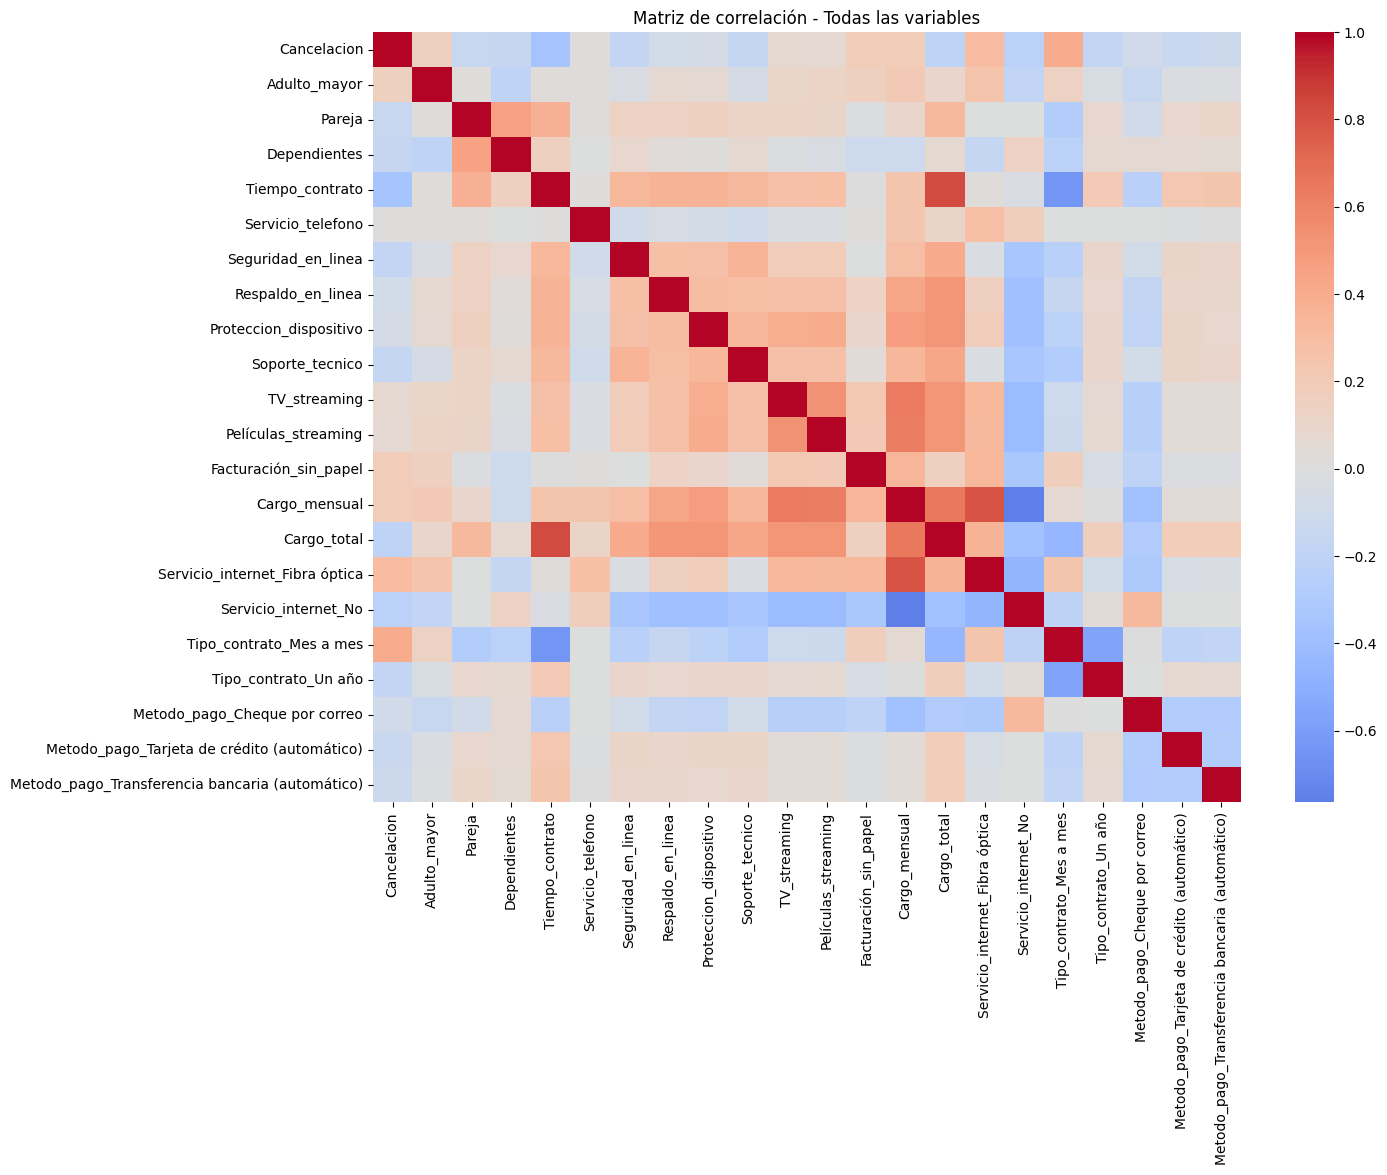

In [23]:
# Visualizar la matriz completa
plt.figure(figsize=(14, 10))
sns.heatmap(matriz_correlacion, cmap='coolwarm', annot=False, fmt=".2f", center=0)
plt.title('Matriz de correlación - Todas las variables')
plt.show()

In [27]:
# Correlación con la variable objetivo (Cancelacion)
cor_target = matriz_correlacion['Cancelacion'].drop('Cancelacion').sort_values(key=abs, ascending=False)
print("Top 10 variables más correlacionadas con Cancelacion:\n")
print(cor_target.head(10))
print("\n*Correlaciones fuertes (> |0.3|): Posibles predictores útiles.")
print("*Correlaciones muy bajas (< 0.05): Poca relación lineal con la cancelación.")

Top 10 variables más correlacionadas con Cancelacion:

Tipo_contrato_Mes a mes           0.405103
Tiempo_contrato                  -0.352229
Servicio_internet_Fibra óptica    0.308020
Servicio_internet_No             -0.227890
Cargo_total                      -0.199037
Cargo_mensual                     0.193356
Facturación_sin_papel             0.191825
Tipo_contrato_Un año             -0.177820
Seguridad_en_linea               -0.171226
Soporte_tecnico                  -0.164674
Name: Cancelacion, dtype: float64

*Correlaciones fuertes (> |0.3|): Posibles predictores útiles.
*Correlaciones muy bajas (< 0.05): Poca relación lineal con la cancelación.


**Hallazgos preliminares:**
- El tipo de contrato es fuertemente relacionado con la cancelación.
- Servicios de soporte, seguridad y tiempo con la empresa tienen correlaciones negativas, lo cual sugiere que clientes más establecidos o con más servicios cancelan menos.
- Servicios de streaming, facturación electrónica y ciertos métodos de pago también están asociados.

##2.2 Análisis dirigido

Investiga cómo variables específicas se relacionan con la cancelación, tales como:

* **Tiempo de contrato × Cancelación**
* **Gasto total × Cancelación**

Utiliza gráficos como **boxplots** o **scatter plots** para visualizar patrones y posibles tendencias.

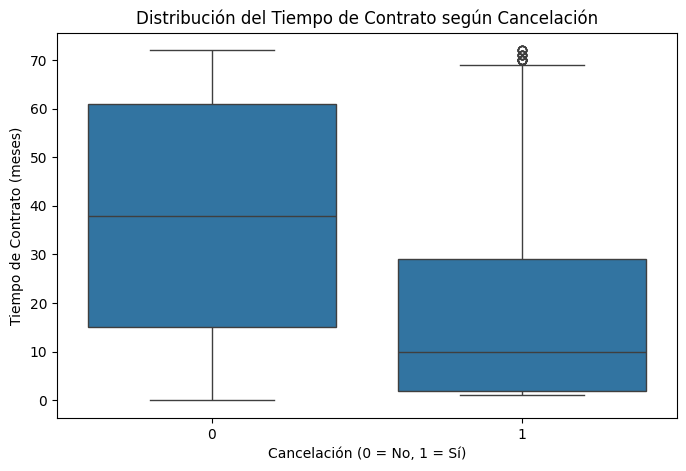

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x='Cancelacion', y='Tiempo_contrato', data=datos_encoded)
plt.title('Distribución del Tiempo de Contrato según Cancelación')
plt.xlabel('Cancelación (0 = No, 1 = Sí)')
plt.ylabel('Tiempo de Contrato (meses)')
plt.show()

- Clientes que cancelan tienden a tener menos tiempo con la empresa.
- Clientes con contratos largos rara vez cancelan.

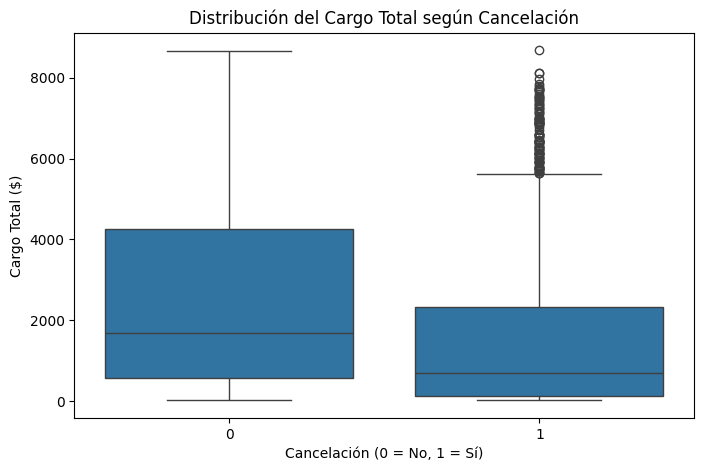

In [29]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Cancelacion', y='Cargo_total', data=datos_encoded)
plt.title('Distribución del Cargo Total según Cancelación')
plt.xlabel('Cancelación (0 = No, 1 = Sí)')
plt.ylabel('Cargo Total ($)')
plt.show()

- Clientes que han pagado poco en total (porque llevan poco tiempo) tienden a cancelar más.
- Clientes con más gasto acumulado probablemente estén más fidelizados.

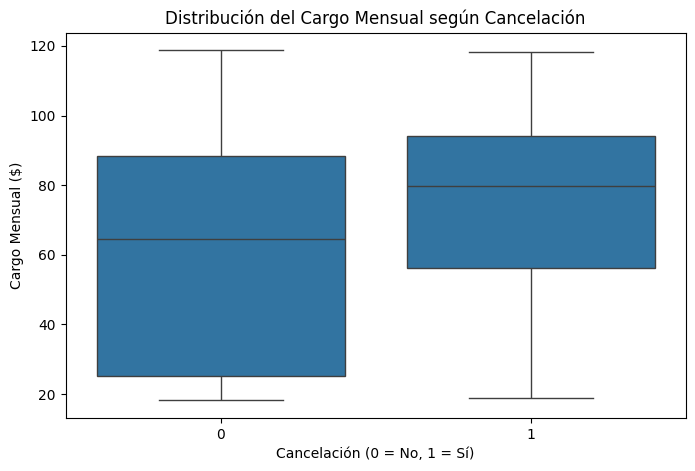

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Cancelacion', y='Cargo_mensual', data=datos_encoded)
plt.title('Distribución del Cargo Mensual según Cancelación')
plt.xlabel('Cancelación (0 = No, 1 = Sí)')
plt.ylabel('Cargo Mensual ($)')
plt.show()

- A veces, cargos mensuales más altos están asociados con mayor churn, especialmente si no hay percepción de valor.

#3. 🤖 Modelado predictivo

##3.1 Separación de datos

Divide el conjunto de datos en **entrenamiento** y **prueba** para evaluar el rendimiento del modelo. Una división común es **70% para entrenamiento** y **30% para prueba**, o **80/20**, dependiendo del tamaño de la base de datos.

Previamente se realizo el punto opcional de balanceo de cargas donde se usa SMOTE, para el cual es necesario previamente realizar la separacion de datos usando ```train_test_split```, por lo que este punto queda resuelto en e. punto 1.5. Igualmente se deja el codigo aplicado anteriormente, sin ejecutar, solo como referencia.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

X = datos_encoded.drop('Cancelacion', axis=1)
y = datos_encoded['Cancelacion']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

##3.2 Creación de modelos

Crea al menos dos modelos diferentes para predecir la cancelación de clientes.

Un modelo puede requerir normalización, como **Regresión Logística** o **KNN**.

El otro modelo puede no requerir normalización, como **Árbol de Decisión** o **Random Forest**.

💡 La decisión de aplicar o no la normalización depende de los modelos seleccionados. Ambos modelos pueden ser creados sin normalización, pero también es una opción combinar modelos con y sin normalización.

**Justificación:**

- **Regresión Logística / KNN:** Estos modelos son sensibles a la escala de los datos, por lo que la normalización es importante para que los coeficientes o las distancias se calculen correctamente.
- **Árbol de Decisión / Random Forest:** Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalización.

Si decides normalizar los datos, deberías explicar cómo esta etapa asegura que los modelos basados en distancia o en optimización de parámetros no se vean sesgados por la magnitud de las variables.

Modelo 1: Regresion Logística

Para el modelo se utilizan los datos previamente estandarizados con ```StandardScaler``` en el punto 1.6

In [31]:
from sklearn.linear_model import LogisticRegression

# Creación y entrenamiento del modelo
modelo_log = LogisticRegression(max_iter=1000, random_state=42)
modelo_log.fit(X_train_bal_scaled, y_train_bal)
y_pred_log = modelo_log.predict(X_test_scaled)

Modelo 2: random Forest

Para el modelo se utilizan los datos previamente balanceados sin estandarizar

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Creación y entrenamiento del modelo
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_bal, y_train_bal)
y_pred_rf = modelo_rf.predict(X_test)

##3.3 Evaluación de los modelos

Evalúa cada modelo utilizando las siguientes métricas:

- **Exactitud (Acurácia)**
- **Precisión**
- **Recall**
- **F1-score**
- **Matriz de confusión**

Después, realiza un análisis crítico y compara los modelos:

- ¿Cuál modelo tuvo el mejor desempeño?
- ¿Algún modelo presentó **overfitting** o **underfitting**? Si es así, considera las posibles causas y ajustes:
  - **Overfitting**: Cuando el modelo aprende demasiado sobre los datos de entrenamiento, perdiendo la capacidad de generalizar a nuevos datos. Considera reducir la complejidad del modelo o aumentar los datos de entrenamiento.
  - **Underfitting**: Cuando el modelo no captura bien las tendencias de los datos, lo que indica que es demasiado simple. Intenta aumentar la complejidad del modelo o ajustar sus parámetros.

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Función de evaluación y matriz de confusión
def evaluar_modelo(nombre_modelo, y_test, y_pred):
    print(f"Evaluación del modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:", round(recall_score(y_test, y_pred), 4))
    print("F1-score:", round(f1_score(y_test, y_pred), 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Canceló', 'Canceló'], yticklabels=['No Canceló', 'Canceló'])
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

Evaluación del modelo: Regresión Logística
Accuracy: 0.7553
Precision: 0.5301
Recall: 0.6916
F1-score: 0.6002

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      1552
           1       0.53      0.69      0.60       561

    accuracy                           0.76      2113
   macro avg       0.70      0.73      0.71      2113
weighted avg       0.78      0.76      0.76      2113



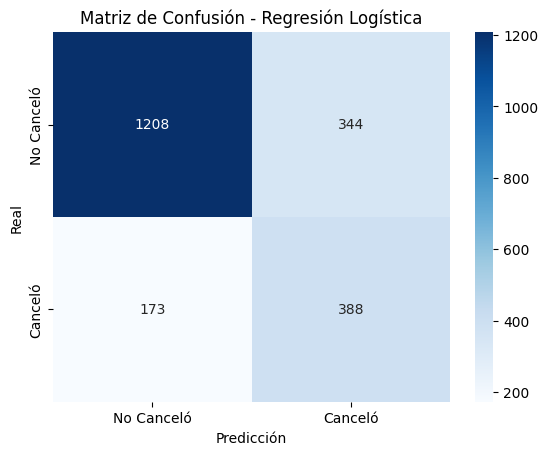

In [36]:
evaluar_modelo("Regresión Logística", y_test, y_pred_log)

Evaluación del modelo: Random Forest
Accuracy: 0.7638
Precision: 0.5487
Recall: 0.6221
F1-score: 0.5831

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1552
           1       0.55      0.62      0.58       561

    accuracy                           0.76      2113
   macro avg       0.70      0.72      0.71      2113
weighted avg       0.77      0.76      0.77      2113



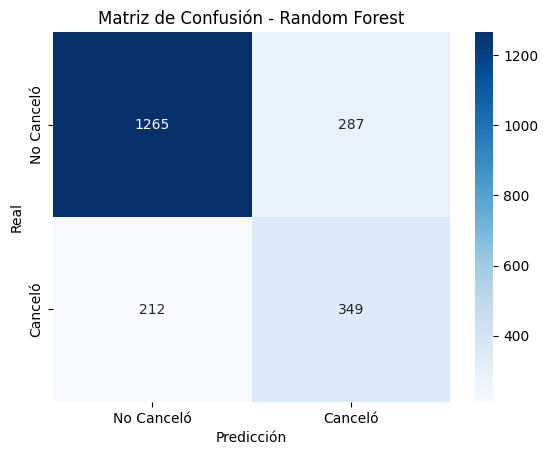

In [37]:
evaluar_modelo("Random Forest", y_test, y_pred_rf)

**Observaciones:**

- Si el modelo tiene alta accuracy pero bajo recall, está ignorando muchos casos reales de cancelación.
- Si tiene alta precision pero bajo recall, es muy conservador (solo predice cancelación cuando está muy seguro).
- Random Forest suele tener mejor recall, mientras que Regresión Logística puede ser más interpretable.

#4. 📋 Interpretación y conclusiones

##4.1 Análisis de la importancia de las variables

Después de elegir los modelos, realiza el análisis de las variables más relevantes para la predicción de la cancelación:

- **Regresión Logística**: Investiga los coeficientes de las variables, que muestran su contribución a la predicción de cancelación.
- **KNN (K-Nearest Neighbors)**: Observa cómo los vecinos más cercanos influyen en la decisión de clasificación. Las variables más impactantes pueden ser aquellas que más contribuyen a la proximidad entre los puntos de datos.
- **Random Forest**: Utiliza la importancia de las variables proporcionada por el modelo. Random Forest calcula la importancia basándose en cómo cada variable contribuye a la reducción de la impureza durante las divisiones de los árboles.
- **SVM (Support Vector Machine)**: En el SVM, las variables más relevantes son aquellas que influyen en la frontera de decisión entre las clases. Puedes analizar los coeficientes de los vectores de soporte para entender qué variables tienen mayor impacto.
- **Otros Modelos**: Dependiendo del modelo elegido, considera el análisis de métricas específicas para comprender la relevancia de las variables. Por ejemplo, coeficientes en modelos lineales, pesos en redes neuronales, o la importancia relativa en técnicas de boosting (como XGBoost).

### 4.1.1 Regresión Logística – Coeficientes

In [41]:
import pandas as pd
import numpy as np

# Obtener coeficientes
coeficientes = modelo_log.coef_[0]

# Asociar con nombres de columnas
importancia_log = pd.Series(coeficientes, index=X_train_bal.columns)

# Ordenar por valor absoluto
importancia_log = importancia_log.sort_values(key=np.abs, ascending=False)

# Mostrar
print("Variables más influyentes según Regresión Logística:\n")
print(importancia_log.head(10))

Variables más influyentes según Regresión Logística:

Cargo_mensual                     3.328892
Tiempo_contrato                  -1.892547
Cargo_total                       1.369565
Tipo_contrato_Mes a mes           1.138524
Servicio_telefono                -0.979383
Servicio_internet_Fibra óptica   -0.927877
Servicio_internet_No              0.759969
Tipo_contrato_Un año              0.628528
Soporte_tecnico                  -0.572743
Películas_streaming              -0.562829
dtype: float64


- Valores positivos → aumentan la probabilidad de cancelación
- Valores negativos → disminuyen la probabilidad de cancelación
- Cuanto mayor la magnitud, más influencia tiene la variable

### 4.1.2 Random Forest – Importancia de variables

In [42]:
# Obtener importancia
importancia_rf = pd.Series(modelo_rf.feature_importances_, index=X_train_bal.columns)

# Ordenar
importancia_rf = importancia_rf.sort_values(ascending=False)

# Mostrar
print("Variables más importantes según Random Forest:\n")
print(importancia_rf.head(10))

Variables más importantes según Random Forest:

Cargo_mensual                     0.160573
Cargo_total                       0.156595
Tiempo_contrato                   0.147932
Tipo_contrato_Mes a mes           0.136628
Servicio_internet_Fibra óptica    0.065304
Soporte_tecnico                   0.043052
Pareja                            0.032695
Seguridad_en_linea                0.032584
Dependientes                      0.030713
Respaldo_en_linea                 0.023967
dtype: float64


- Las variables con mayor peso son las que más ayudaron a dividir los datos en los árboles.
- No indica dirección (positiva o negativa), pero sí relevancia para la predicción.

### 4.1.3 Gráfico de coeficientes para Regresión Logística

/tmp/ipython-input-1721052559.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_log.values, y=top_log.index, palette=colors)


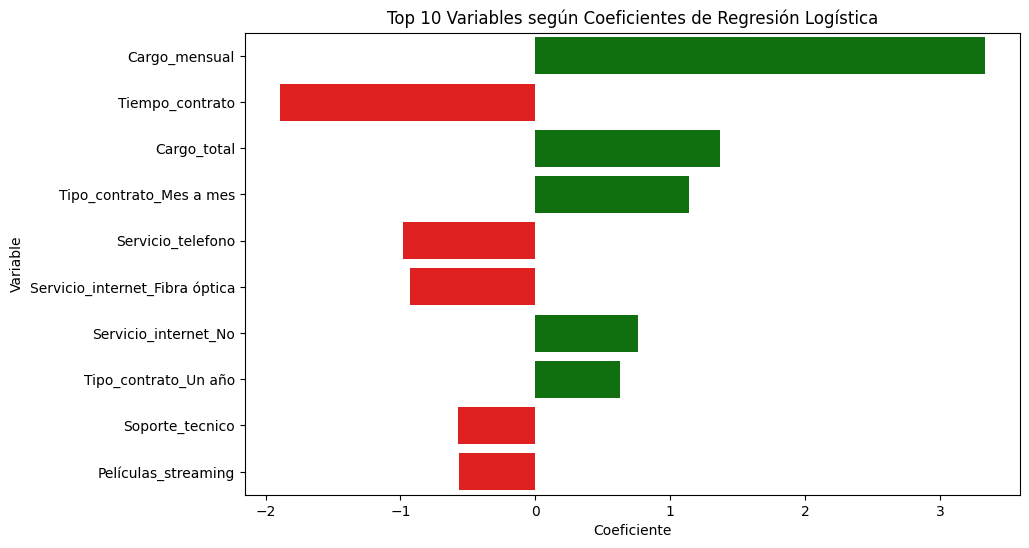

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tomamos las 10 variables con mayor valor absoluto en coeficientes
top_log = importancia_log.head(10)

plt.figure(figsize=(10,6))
colors = ['red' if c < 0 else 'green' for c in top_log.values]
sns.barplot(x=top_log.values, y=top_log.index, palette=colors)
plt.title('Top 10 Variables según Coeficientes de Regresión Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.show()

En este gráfico, las barras verdes indican que la variable aumenta la probabilidad de cancelación, y las rojas que la disminuyen.

###4.1.4 Gráfico de importancia para Random Forest

/tmp/ipython-input-3839808238.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rf.values, y=top_rf.index, palette='viridis')


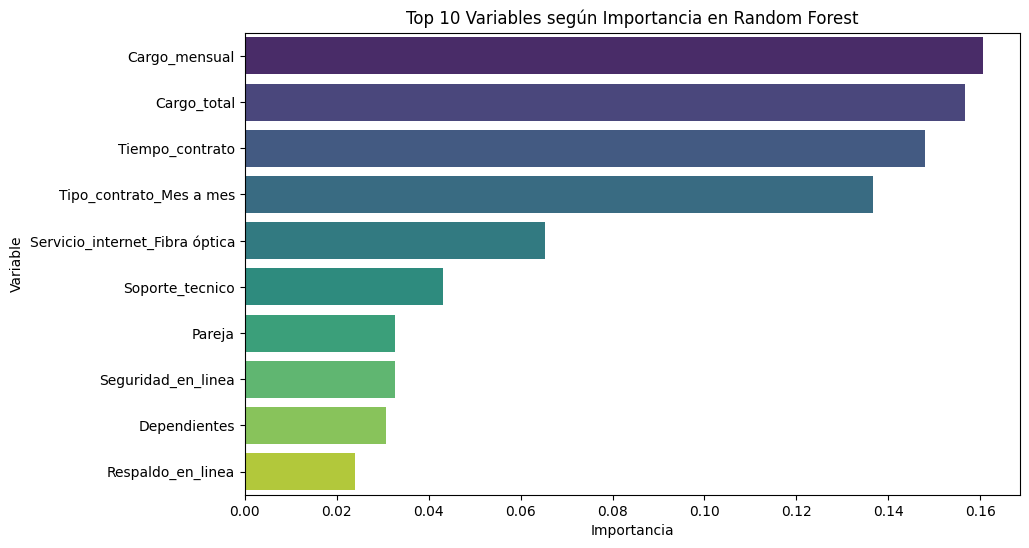

In [45]:
# 10 variables más importantes
top_rf = importancia_rf.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_rf.values, y=top_rf.index, palette='viridis')
plt.title('Top 10 Variables según Importancia en Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

##4.2 Conclusión

Elaboren un informe detallado, destacando los factores que más influyen en la cancelación, basándose en las variables seleccionadas y en el rendimiento de cada modelo.

Identifiquen los **principales factores** que afectan la cancelación de clientes y propongan estrategias de retención basadas en los resultados obtenidos.

### 4.2.1 Informe sobre análisis y modelado de cancelación de clientes (Churn)

#### A. Introducción

El objetivo de este análisis es la identificación de auqellos factores que influyen sobre la cancelación de clientes (churn) y con ello, construir modelos predictivos de ML que permitan anticipar dicha cancelación con el fin de implementar estrategias efectivas de retención clientes previo a su salida teórica.

#### B. Preprocesamiento de datos

- **Eliminación de columnas irrelevantes:** Primero se eliminaron aquellas columnas que no aportan valor predictivo, principalmente el identificador único ```ID_Cliente```, para evitar ruido en el modelo. Ademas, se analizaron variables candidatas adicionales y se concluyó que todas las demás variables son relevantes para el análisis, ya que muestran correlaciones, o aportan información clave sobre el comportamiento del cliente.
- **Encoding y transformación:** Aquellas variables categóricas como ```Genero```, ```Servicio_internet```, ```Tipo_contrato```, ```Metodo_pago```, fueron transformadas a variables numéricas mediante One-Hot Encoding, asegurando la compatibilidad con modelos de machine learning.
- **Balanceo de clases:** Se detectó la presencia de un desbalance moderado en la variable objetivo ```Cancelacion```. Para abordarlo, se aplicó la técnica SMOTE en el conjunto de entrenamiento para generar ejemplos sintéticos de la clase minoritaria, con la finalidad de mejorar el aprendizaje del modelo.
- **Normalización:** Se aplicó una estandarización (StandardScaler) sobre las variables numéricas para los modelos sensibles a la escala como Regresión Logística y KNN.

#### C. Análisis exploratorio y correlacional

- Se creo y visualizo la matriz de correlación para identificar relaciones fuertes con la variable ```Cancelacion```.
- Variables como ```Tiempo_contrato```, ```Cargo_mensual``` y ```Cargo_total``` mostraron una correlación significativa con la cancelación.
- Se analizaron patrones específicos entre las variables clave como tiempo de contrato vs cancelación, gasto total vs cancelación, usando graficas boxplots y scatter plots.

#### D. Modelado Predictivo
- **División de datos:** Se dividió el conjunto en entrenamiento y prueba (80/20). SMOTE se aplicó sólo sobre el conjunto de entrenamiento para evitar filtraciones, haciendo que el modelo se entrene con información que, en parte, está también presente en el test provocando que la evaluación del modelo ya no fuese confiable, porque el test ya no representa datos reales.
- **Modelos entrenados:**
  - Regresión Logística: Usando datos estandarizados.
  - Random Forest: Usando datos sin escalar.
- **Evaluación:** Ambos modelos fueron evaluados con métricas de precisión, recall, F1-score, accuracy y matriz de confusión. Random Forest mostró mejor balance entre recall y precisión.

#### E. Interpretación de Resultados
- **Importancia de variables:**
  - En el modelo de Regresión Logística los coeficientes indicaron que ```Tiempo_contrato``` es un factor protector (coeficiente negativo), mientras que ```Cargo_mensual``` incrementa el riesgo de cancelación.
  - En el modelo de Random Forest las variables más importantes coincidieron con las de Regresión Logística, lo que refuerza la validez de los hallazgos previos.

/tmp/ipython-input-2235009139.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_log.values, y=top_log.index, palette=colors)


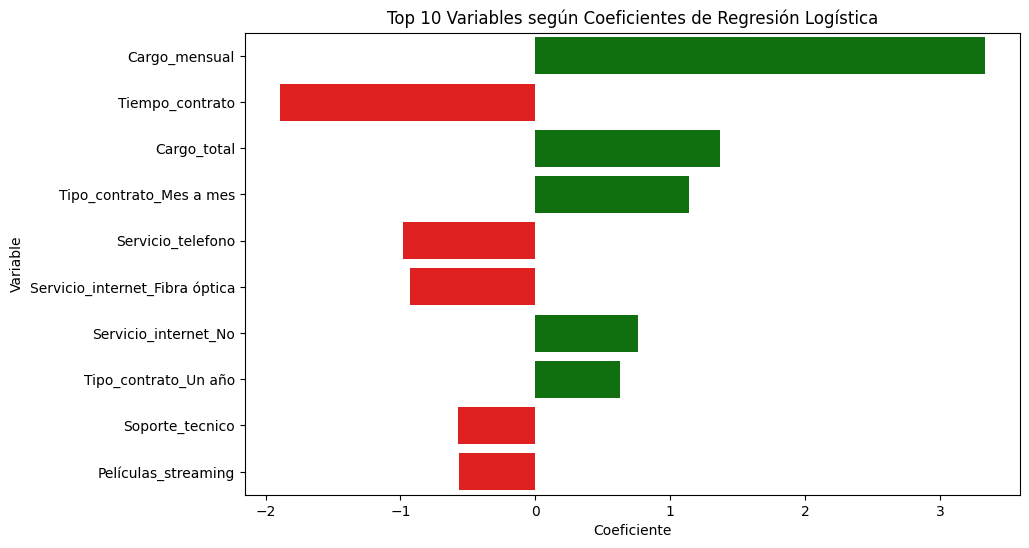

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

top_log = importancia_log.head(10)
plt.figure(figsize=(10,6))
colors = ['red' if c < 0 else 'green' for c in top_log.values]
sns.barplot(x=top_log.values, y=top_log.index, palette=colors)
plt.title('Top 10 Variables según Coeficientes de Regresión Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.show()

/tmp/ipython-input-669768591.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rf.values, y=top_rf.index, palette='viridis')


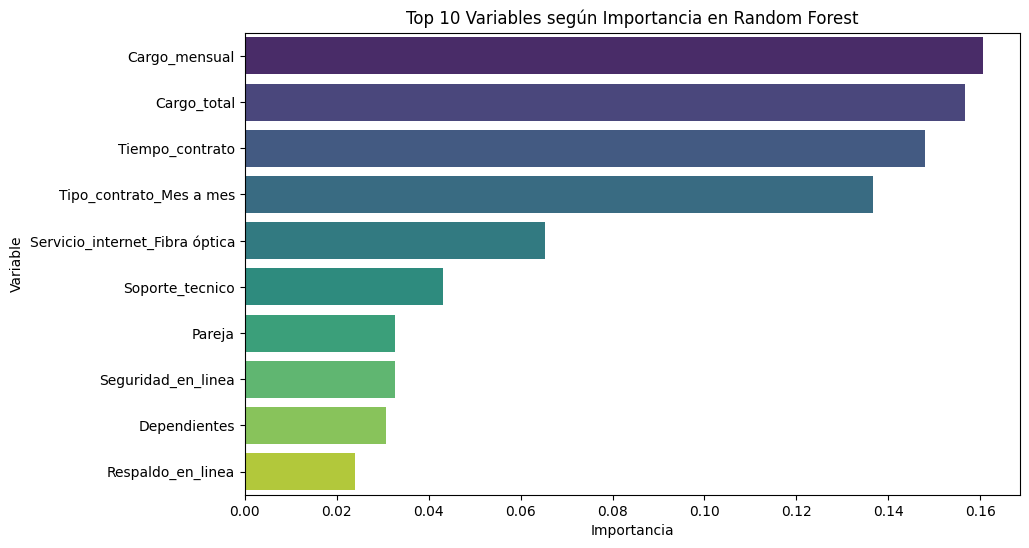

In [47]:
top_rf = importancia_rf.head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_rf.values, y=top_rf.index, palette='viridis')
plt.title('Top 10 Variables según Importancia en Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

- **Conclusiones:**
  - Clientes con contratos más largos tienden a permanecer más tiempo.
  - Costos elevados están asociados a mayor probabilidad de churn.
  - Tipo de contrato y método de pago también influyen en la cancelación.

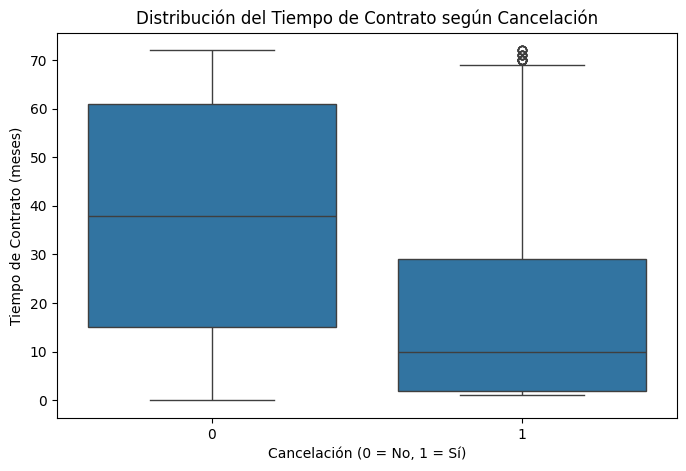

In [49]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Cancelacion', y='Tiempo_contrato', data=datos_encoded)
plt.title('Distribución del Tiempo de Contrato según Cancelación')
plt.xlabel('Cancelación (0 = No, 1 = Sí)')
plt.ylabel('Tiempo de Contrato (meses)')
plt.show()

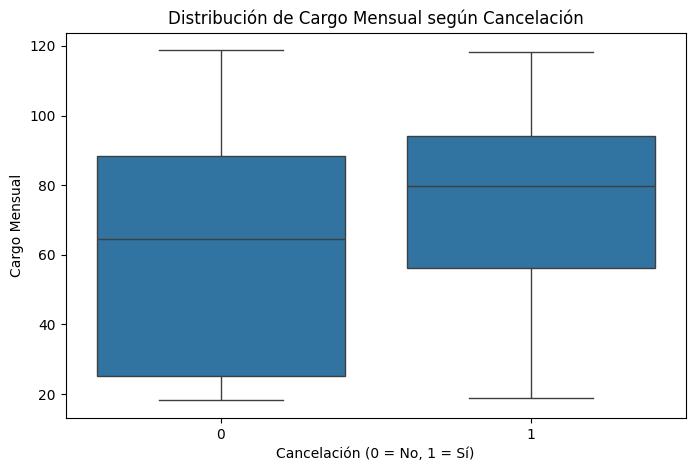

In [50]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Cancelacion', y='Cargo_mensual', data=datos_encoded)
plt.title('Distribución de Cargo Mensual según Cancelación')
plt.xlabel('Cancelación (0 = No, 1 = Sí)')
plt.ylabel('Cargo Mensual')
plt.show()

#### F. Recomendaciones Estratégicas

- Promover contratos de mayor duración para fidelizar clientes.
- Revisar y ajustar tarifas para mejorar competitividad y reducir cancelación.
- Incentivar métodos de pago automáticos y confiables.
- Mejorar la oferta y calidad de servicios complementarios para aumentar la satisfacción.

#### Resumen Ejecutivo

Este análisis integral sobre la cancelación de clientes identificó aquellos principales factores que afectan la permanencia de clientes en la compañia, donde se destacan el tiempo de contrato y los cargos como variables determinantes. Durante el proceso se entrenaron dos modelos predictivos: Regresión Logística y Random Forest. Ambos modelos demostraron un desempeño sólido, siendo Random Forest el que presenta una mejor eficacia en identificar clientes que cancelan.

Según estos hallazgos, se recomienda el desarrollo e implementación de estrategias enfocadas a la fidelización de clientes mediante contratos largos, ajuste de tarifas en los servicios y mejoras en las opciones de métodos de pago y de servicios, con la finalidad de lograr reducir significativamente la tasa de cancelación y aumentar la retención de clientes.